Simple VAE network based on the example on https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/ 
<br>
Migrated to Pytorch 0.4.0 and added visualization to try different parametrization for the network

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import matplotlib.pyplot as plt
#A function for visualization of results
def show(img):
    if device.type == 'cuda': 
        img = img.cpu()
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [3]:
#Define paramaters
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
LOG_INTERVAL = 50

Z_DIMS = 20
HIDDEN_N = 400

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

In [4]:
#VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.fc1  = nn.Linear(784, HIDDEN_N)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(HIDDEN_N, Z_DIMS)
        self.fc22 = nn.Linear(HIDDEN_N, Z_DIMS)
        self.fc3  = nn.Linear(Z_DIMS, HIDDEN_N)
        self.fc4  = nn.Linear(HIDDEN_N, 784)
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        #sample eps from normal distribution
        eps = torch.randn([mu.size()[0], Z_DIMS]).to(device)
        z = 0.5*logvar.exp()*eps + mu
        return z
    
    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        out = self.sigmoid(self.fc4(h3))
        return out
        
    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

In [5]:
def loss_function(recon_x, x, mu, logvar):
    #measure of how well reconstruction matches input
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
    #measure of distance btw learned distribution and Normal Gaussian
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * 784
    return BCE + KLD

In [6]:
#LOAD MNIST DATASET
train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./data', train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=BATCH_SIZE, shuffle=True)
    
# Same for test data
test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
                batch_size=BATCH_SIZE, shuffle=True)

In [7]:
#Instantiate network and optimizer
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:

def train(epoch):
    model.train()
    train_loss = 0
    loss_history = list()
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            loss_history.append(loss.item())
            
    print('====> Epoch: {} Average loss: {:.5f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    return loss_history

def test(epoch):
    model.eval()
    test_loss = 0
    
    # each data is BATCH_SIZE samples
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader): 
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                # for the first 128 batch of the epoch, show the first 8 input digits
                # with right below them the reconstructed output digits
                print('Original')
                show(make_grid(data[:n]))
                print('Reconstructed')
                show(make_grid(recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n].cpu()))

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.5f}'.format(test_loss))

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.005436
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.002104
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001720
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.001470
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.001373
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.001322
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.001217
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.001187
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.001191
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.001124
====> Epoch: 1 Average loss: 0.00151
Training time for epoch: 6.54s
Original


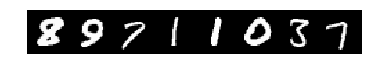

Reconstructed


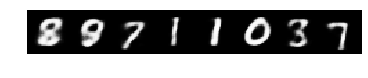

====> Test set loss: 0.00110
Generating samples


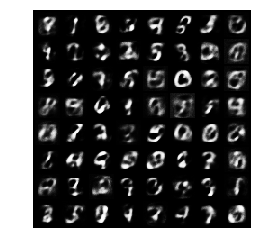

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.001054
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.001049
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.001052
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.001025
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.001036
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.001025
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.001044
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.001022
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.001000
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.000971
====> Epoch: 2 Average loss: 0.00103
Training time for epoch: 6.34s
Original


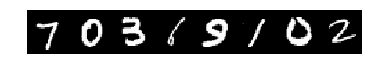

Reconstructed


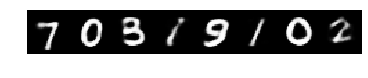

====> Test set loss: 0.00098
Generating samples


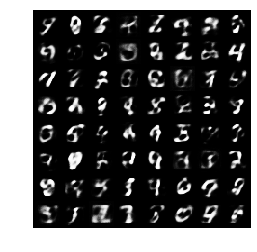

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000954
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.000959
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.000978
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.000930
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000931
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000964
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.000964
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.000928
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000924
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.000947
====> Epoch: 3 Average loss: 0.00095
Training time for epoch: 6.35s
Original


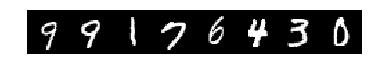

Reconstructed


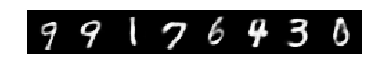

====> Test set loss: 0.00093
Generating samples


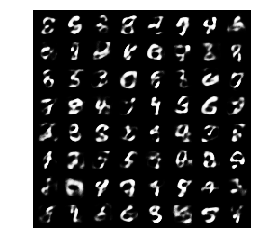

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000954
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.000921
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000949
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.000965
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000890
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.000891
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000931
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.000926
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000936
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.000905
====> Epoch: 4 Average loss: 0.00092
Training time for epoch: 6.23s
Original


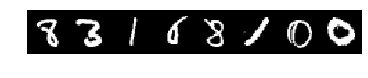

Reconstructed


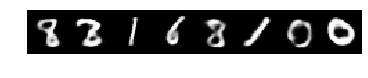

====> Test set loss: 0.00091
Generating samples


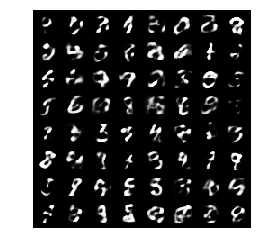

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000907
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000916
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000891
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.000881
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000933
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000864
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000896
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000916
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000901
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000888
====> Epoch: 5 Average loss: 0.00090
Training time for epoch: 6.28s
Original


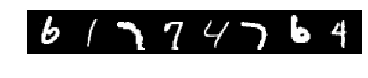

Reconstructed


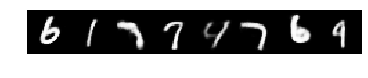

====> Test set loss: 0.00089
Generating samples


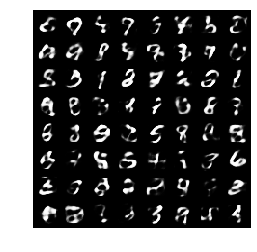

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000833
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000871
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000874
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000868
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000825
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000870
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000864
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000874
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000844
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000899
====> Epoch: 6 Average loss: 0.00088
Training time for epoch: 6.37s
Original


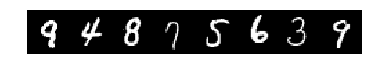

Reconstructed


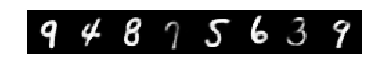

====> Test set loss: 0.00088
Generating samples


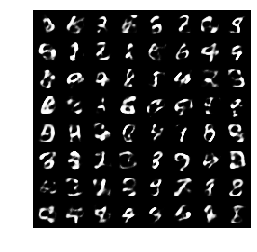

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000867
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000882
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000899
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000830
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000943
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000902
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000899
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000928
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000885
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000889
====> Epoch: 7 Average loss: 0.00087
Training time for epoch: 6.33s
Original


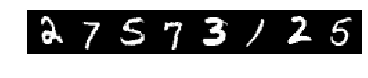

Reconstructed


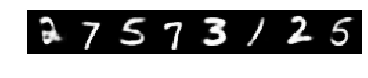

====> Test set loss: 0.00087
Generating samples


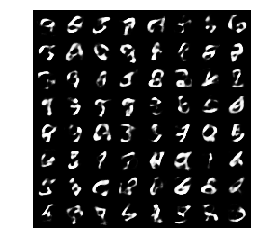

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000887
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000849
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000865
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000872
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000852
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000851
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000879
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000802
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000863
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000868
====> Epoch: 8 Average loss: 0.00087
Training time for epoch: 6.20s
Original


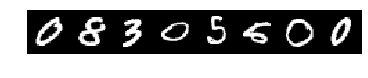

Reconstructed


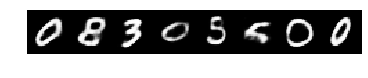

====> Test set loss: 0.00087
Generating samples


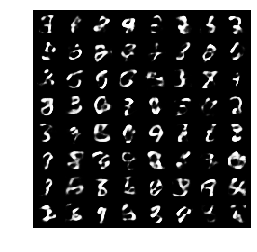

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000860
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000894
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000856
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000865
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000820
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000860
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000852
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000873
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000890
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000845
====> Epoch: 9 Average loss: 0.00086
Training time for epoch: 6.44s
Original


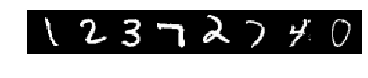

Reconstructed


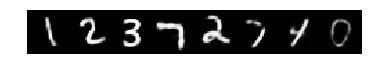

====> Test set loss: 0.00086
Generating samples


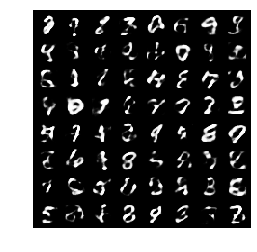

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000902
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000881
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000846
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000847
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000886
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000836
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000855
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000852
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000825
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000837
====> Epoch: 10 Average loss: 0.00086
Training time for epoch: 6.46s
Original


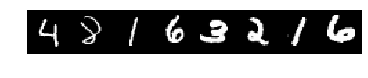

Reconstructed


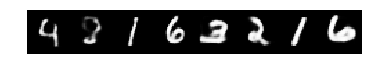

====> Test set loss: 0.00086
Generating samples


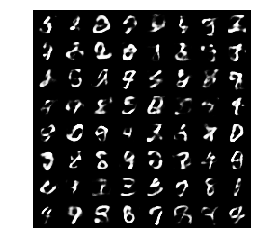

In [10]:
import time
loss_history = list()
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    hist = train(epoch)    ## TRAIN
    loss_history.extend(hist)
    end = time.time()
    print('Training time for epoch: {:.2f}s'.format(end-start))
    test(epoch)
        
    
    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    print('Generating samples')
    with torch.no_grad():
        z_sample = torch.randn(64, Z_DIMS).to(device)
        sample = model.decode(z_sample)
        show(make_grid(sample.view(-1, 1, 28, 28).cpu()))   
    print('======================================================')

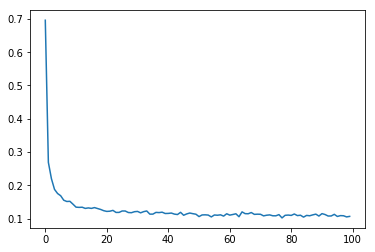

In [11]:
#plot loss
plt.plot(loss_history)